In [195]:
# Script to clean capacity values of SWIS compost sites and make spatial

# First, load packages
import pandas as pd
import os
import numpy as np
import shapely as sp

import matplotlib.pyplot as plt
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame
# only for jupyter nb to show plots inline
#%matplotlib inline 


In [196]:
#check wd
#print(os.getcwd())

#change wd
os.chdir("/Users/anayahall/projects/grapevine")

#read in compost facilities csv
df = pd.read_csv("data/interim/swis_compost.csv")

In [197]:
df.columns
#df.head()
#df.tail()
#df.info()

Index(['SwisNo', 'Name', 'County', 'Location', 'Place', 'Latitude',
       'Longitude', 'Category', 'Activity', 'OperationalStatus',
       'AcceptedWaste', 'Throughput', 'ThroughputUnits', 'Capacity',
       'CapacityUnits', 'Acreage', 'RemainingCapacity'],
      dtype='object')

In [198]:
df.County.value_counts(dropna=False).head()

Riverside         10
Tulare            10
San Bernardino    10
Los Angeles        9
Napa               6
Name: County, dtype: int64

In [199]:
df['CapacityUnits'].value_counts(dropna=False)

Tons/year         61
Cu Yards/year     31
Cubic Yards       10
NaN               10
Tons               3
Tons/day           2
Tires/day          1
Cu Yards/month     1
Name: CapacityUnits, dtype: int64

In [200]:
# Identify and recode oddly labeled capacity units (those lacking time unit)
# first: Tons
df[df.CapacityUnits=="Tons"]

n = len(df.index)
for i in range(n):
#     print("index: ", i)
    if df.SwisNo[i] == "13-AA-0095": 
        df.at[i, 'CapacityUnits'] = "Tons/year"
    if df.SwisNo[i]=="49-AA-0422": 
        df.at[i, 'CapacityUnits'] = "Tons/year"
    if df.SwisNo[i]=="36-AA-0456": 
        df.at[i, 'CapacityUnits'] = "Tons/year"
        
# foo = df[df.CapacityUnits=="Tons/Year"]
# print('foo', foo)

In [201]:
#df[df.CapacityUnits=="Cubic Yards"]


n = len(df.index)
for i in range(n):
    #print("index: ", i)
    if df.SwisNo[i]=="12-AA-0113": 
        df.at[i, 'CapacityUnits']="Cu Yards/month"
    if df.SwisNo[i]=="44-AA-0013": 
        df.at[i, 'CapacityUnits']="Cu Yards/month"
    if df.SwisNo[i]=="28-AA-0037": 
        df.at[i, 'CapacityUnits']="Cu Yards/month"
    if df.SwisNo[i]=="37-AA-0992": 
         df.at[i, 'CapacityUnits']="Cu Yards/year"
    if df.SwisNo[i]=="37-AB-0011": 
         df.at[i, 'CapacityUnits']="Cu Yards/year"
    if df.SwisNo[i]=="43-AA-0015": 
         df.at[i, 'CapacityUnits']="Cu Yards/year"
    if df.SwisNo[i]=="11-AA-0039": 
         df.at[i, 'CapacityUnits']="Cu Yards/year"            
            
        

df[df.CapacityUnits=="Cubic Yards"]

,SwisNo,Name,County,Location,Place,Latitude,Longitude,Category,Activity,OperationalStatus,AcceptedWaste,Throughput,ThroughputUnits,Capacity,CapacityUnits,Acreage,RemainingCapacity
4,28-AA-0002,Clover Flat Resource Recovery Park,Napa,4380 Silverado Trail Road,Calistoga,38.58400,-122.53400,Composting,Composting Facility (Other),Active,"Food Wastes,Green Materials",2500.0,Cubic Yards,2500.0,Cubic Yards,NaN,NaN
29,19-AR-1226,Van Norman Chipping and Grinding Fac,Los Angeles,11701 Blucher Ave,Granada Hills (In Los Angeles),34.28889,-118.48028,Composting,Chipping and Grinding Activity Fac./ Op.,Active,Green Materials,499.0,Cubic Yards,78000.0,Cubic Yards,7.0,NaN
102,54-AA-0059,Hofstee Farms,Tulare,16029 Ave. 139,Tipton,36.15457,-119.25539,Composting,Composting Operation (Ag),Active,"Agricultural,Manure",9500.0,Cubic Yards,9500.0,Cubic Yards,7.0,NaN


In [202]:
# first filter out all th
df = df[df['Capacity'].notnull()]

df.reset_index(inplace=True)

df['cap_m3'] = 0.0

# print("df index length: ", len(df.index))

df.tail()


,index,SwisNo,Name,County,Location,Place,Latitude,Longitude,Category,Activity,OperationalStatus,AcceptedWaste,Throughput,ThroughputUnits,Capacity,CapacityUnits,Acreage,RemainingCapacity,cap_m3
104,114,35-AA-0032,Central Coast Compost LLC,San Benito,1206 Shore Rd.,Hollister,36.95164,-121.43727,Composting,Composting Operation (Ag),Active,"Agricultural,Manure",12000.0,Tons/year,12000.0,Tons/year,15.0,NaN,0.0
105,115,54-AA-0062,Slover Bros Trucking Inc.,Tulare,24861 Road 148,Tulare,36.23989,-119.24262,Composting,Composting Operation (Ag),Active,"Agricultural,Manure",500.0,Tons/day,30000.0,Tons/year,10.0,NaN,0.0
106,116,54-AA-0063,Slover Bros Trucking Inc.,Tulare,North of Ave. 248 East Side of Road 148,Tulare,36.24034,-119.24284,Composting,Composting Operation (Ag),Active,Manure,500.0,Tons/day,30000.0,Tons/year,5.0,NaN,0.0
107,117,54-AA-0064,Slover Bros Trucking Inc.,Tulare,South of Ave 256 on Road 148,Tulare,36.24113,-119.24308,Composting,Composting Operation (Ag),Active,Manure,5000.0,Tons/day,30000.0,Tons/year,5.0,NaN,0.0
108,118,33-AA-0370,Rios Recycling C&D Wood Chip & Grind,Riverside,5190 Wilson Ave,Riverside,34.01879,-117.37271,Composting,Chipping and Grinding Activity Fac./ Op.,Active,"Construction/demolition,Green Materials,Wood w...",200.0,Tons/day,62040.0,Tons/year,3.2,NaN,0.0


In [203]:
# write function to convert all capacity units into cubic meters/month!

#how to assign values:
# df.at[i, 'CapacityUnits'] = "Tons/year"

print("CLEANING CAPACITY - CONVERT TO CUBIC METERS / MONTH")
n = len(df.index)
for i in range(n):
    #print("index: ", i)
    if df.CapacityUnits[i] == "Tons/year":
        # print("tons/year")
        # tons/year * cu yards/ton * cu meters/cu yards * years/month 
        #df.cap_m3[i] = df.Capacity[i] * 2.24 * 0.764555 * (1/12)
        df.at[i, 'cap_m3'] = df.Capacity[i] * 2.24 * 0.764555 * (1/12)
        # print(df.cap_m3[i])
    elif df.CapacityUnits[i] == "Cu Yards/year":
        # print("cu yrds/year")
        # cu yards/year * cu meters/cu yards * years/month 
        df.at[i, 'cap_m3'] = df.Capacity[i] * 0.764555 * (1/12)
        # print(df.cap_m3[i])
    elif df.CapacityUnits[i] == "Cubic Yards":
        print("index: ", i ," - cu yrds --- NEED TO DISENTANGLE STILL!")
        # print(df.cap_m3[i])
    elif df.CapacityUnits[i] == "Tons":
        print("tons") #there should be none of these
        # print(df.cap_m3[i])
    elif df.CapacityUnits[i] == "Tons/day":
        # tons/day * cu yards/ton * cu meters/cu yards * days/year * years/month 
        df.at[i, 'cap_m3'] = df.Capacity[i] * 2.24 * 0.764555 * (365/1) * (1/12)
        # print("tons/day")
        # print(df.cap_m3[i])
    elif df.CapacityUnits[i] == "Cu Yards/month":
        # cu yards/month * cu meters/cu yards 
        df.at[i, 'cap_m3'] = df.Capacity[i] * 0.764555
        # print("cu yrds/month")
        # print(df.cap_m3[i])
    elif df.CapacityUnits[i] == "Tires/day":
        print("index: ", i ," - tires/day - delete? now set capacity at: ", df.cap_m3[i])
        df.at[i, 'cap_m3'] = 0.0
    else:
        print("none of the above")

# will also need a function to convert waste volume into compost volume

CLEANING CAPACITY - CONVERT TO CUBIC METERS / MONTH
index:  4  - cu yrds --- NEED TO DISENTANGLE STILL!
index:  26  - cu yrds --- NEED TO DISENTANGLE STILL!
index:  32  - tires/day - delete? now set capacity at:  0.0
index:  93  - cu yrds --- NEED TO DISENTANGLE STILL!


In [204]:
# Last thing is to make all points spatial
# try using shapely package
# from shapely.geometry import Point

# point = Point(df.Longitude[0], df.Latitude[0])

# df.points = {}

# n = len(df.index)
# for i in range(n):
#     df.points[i] = Point(df.Longitude[i], df.Latitude[i])


In [205]:
df.head()


,index,SwisNo,Name,County,Location,Place,Latitude,Longitude,Category,Activity,OperationalStatus,AcceptedWaste,Throughput,ThroughputUnits,Capacity,CapacityUnits,Acreage,RemainingCapacity,cap_m3
0,0,01-AA-0310,Tri-Cities Rec. and Disp. CD Chip/Grind,Alameda,7010 Auto Mall Pkwy.,Fremont,37.49078,-121.99040,Transfer/Processing,Small Vol CD Wood Debris ChipGrind Op,Active,Wood waste,200.0,Tons/month,62369.0,Tons/year,90.0,NaN,8901.112415
1,1,27-AA-0090,Breien-Eade Compost Venture,Monterey,1 Pine Valley Road,San Ardo,36.12481,-121.00886,Composting,Composting Operation (Ag),Closed,"Agricultural,Manure",40000.0,Cu Yards/year,40000.0,Cu Yards/year,480.0,NaN,2548.516667
2,2,30-AB-0378,Golden Rain Foundation Composting Op.,Orange,24401 Moulton Parkway,Laguna Hills,33.60377,-117.72490,Composting,Composting Operation (Green Waste),Active,Green Materials,20.0,Tons/day,10000.0,Cu Yards/year,3.0,NaN,637.129167
3,3,19-AR-5584,Dept. of Rec. & Parks Greenwaste Rec.,Los Angeles,5400 Griffith Park Dr,Los Angeles (City),34.11722,-118.27222,Composting,Chipping and Grinding Activity Fac./ Op.,Active,Green Materials,50.0,Tons/day,19750.0,Tons/year,3.0,NaN,2818.659433
4,4,28-AA-0002,Clover Flat Resource Recovery Park,Napa,4380 Silverado Trail Road,Calistoga,38.58400,-122.53400,Composting,Composting Facility (Other),Active,"Food Wastes,Green Materials",2500.0,Cubic Yards,2500.0,Cubic Yards,NaN,NaN,0.000000


In [206]:
# Use geopandas instead
# from: https://geohackweek.github.io/vector/04-geopandas-intro/
geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
gdf = GeoDataFrame(df, geometry=geometry)

# check length to make sure it matches df
len(geometry)

109

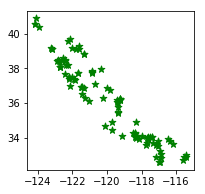

In [207]:
gdf.plot(marker='*', color='green', markersize=50, figsize=(3, 3))

In [208]:
df.head()

,index,SwisNo,Name,County,Location,Place,Latitude,Longitude,Category,Activity,OperationalStatus,AcceptedWaste,Throughput,ThroughputUnits,Capacity,CapacityUnits,Acreage,RemainingCapacity,cap_m3,geometry
0,0,01-AA-0310,Tri-Cities Rec. and Disp. CD Chip/Grind,Alameda,7010 Auto Mall Pkwy.,Fremont,37.49078,-121.99040,Transfer/Processing,Small Vol CD Wood Debris ChipGrind Op,Active,Wood waste,200.0,Tons/month,62369.0,Tons/year,90.0,NaN,8901.112415,POINT (-121.9904 37.49078)
1,1,27-AA-0090,Breien-Eade Compost Venture,Monterey,1 Pine Valley Road,San Ardo,36.12481,-121.00886,Composting,Composting Operation (Ag),Closed,"Agricultural,Manure",40000.0,Cu Yards/year,40000.0,Cu Yards/year,480.0,NaN,2548.516667,POINT (-121.00886 36.12481)
2,2,30-AB-0378,Golden Rain Foundation Composting Op.,Orange,24401 Moulton Parkway,Laguna Hills,33.60377,-117.72490,Composting,Composting Operation (Green Waste),Active,Green Materials,20.0,Tons/day,10000.0,Cu Yards/year,3.0,NaN,637.129167,POINT (-117.7249 33.60377)
3,3,19-AR-5584,Dept. of Rec. & Parks Greenwaste Rec.,Los Angeles,5400 Griffith Park Dr,Los Angeles (City),34.11722,-118.27222,Composting,Chipping and Grinding Activity Fac./ Op.,Active,Green Materials,50.0,Tons/day,19750.0,Tons/year,3.0,NaN,2818.659433,POINT (-118.27222 34.11722)
4,4,28-AA-0002,Clover Flat Resource Recovery Park,Napa,4380 Silverado Trail Road,Calistoga,38.58400,-122.53400,Composting,Composting Facility (Other),Active,"Food Wastes,Green Materials",2500.0,Cubic Yards,2500.0,Cubic Yards,NaN,NaN,0.000000,POINT (-122.534 38.584)


In [215]:
gdf.crs = {'init' :'epsg:3310'}
# save as??? 

out = r"/Users/anayahall/projects/grapevine/data/clean/clean_swis.shp"

type(gdf)

gdf.to_file(driver='ESRI Shapefile', filename=out)

/Users/anayahall/anaconda/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
